# Движение наноспутника в пусковом контейнере

Юдинцев В. В. 2019

_Пример программы моделирования плоского движения наноспутника внутри транспортно-пускового контейнера на языке python с использованием библиотек numpy, scipy, sympy, matplotlib._

In [40]:
# Символные математические преобразоания
import sympy as sp

# Для быстрых подстановок чисел в аналитические выражения 
from sympy.utilities.lambdify import lambdify

# Для печати красивых формул
sp.init_printing()

# Матрицы, массивы
import numpy as np

# Из этого модуля понадобится функция root
from scipy import optimize
# Из этого модуля понадобится функция solve
from scipy import linalg

# Для численного интегрирования дифференциальных уранвений
from scipy.integrate import solve_ivp

# Для графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab

# Настройка стилей графиков
pylab.rcParams.update({'legend.fontsize': 14, 
                       'figure.figsize': (12, 8), 
                       'axes.labelsize': 14,
                       'axes.titlesize':14, 
                       'xtick.labelsize':14,
                       'ytick.labelsize':14})

Рассмотрим _простейшую плоскую_ модель движения наноспутника внутри пускового контейнера.

Предполагаем, что наноспутник при движении в контейнере своим ребром $B$, которое в плоской задаче выродилось в точку, скользит по поверхности направляющей контейнера $B_0D_0$, а ребро $А_0$ контейнера может касаться боковой поверхности наноспутника $DA$.

Наноспутник может двигаться внутри контейнера без соприкосновения с ребром $A_0$, однако до момента выхода из контейнера и пока на наноспутник действует сила пружинного толкателя P, ребро $B$ наноспутника касается поверхности $B_0D_0$. 

![Наноспутник](http://classmech.ru/assets/img/blog/cubesat.png)

Движение наноспутника происходит под действием силы пружинного толкателя $P$ и сил реакций со стороны транспортно-пускового контейнера $R_A$, $R_B$.

Предполагаем, что движение наноспутника в контейнере можно разделить на три этапа, которые отличаются набором  ограничений (связей), накоадываемых на движение наноспутника: 

1 этап: $P>0$, $R_A>0$, $R_B>0$: на наноспутник действует сила пружинного толкателя, наноспутник касается контейнера в двух точках ($A_0$ и $B$). В этих точках на спутник действуют силы реакции $R_A$ и $R_B$.  

2 этап: $P>0$, $R_A=0$, $R_B>0$: на наноспутник действует сила пружинного толкателя, наноспутник касается контейнера в одной точке $B$. 

3 этап: $P=0$, $R_A=0$, $R_B=0$: свободное движение по инерции.


Предполагаемый характер движения наноспутника показан на следующем видео.

In [2]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/THv4-rbR3-g" frameborder="0" allow="autoplay; encrypted-media;"></iframe>

## Уравнения движения

Положение наноспутника задается относительно неподвижной системы координат $Oy_0z_0$, связанной с контейнером. Положение определяется тремя координатами: координатами центра масс $y$, $z$ и углом $\beta$ между направляющей конейнера и ребром наноспутника. 

Учитывая изменение в процессе движения наноспутника количества кинематических связей, удобней для записи уравнений движения использовать теорему о движении центра масс и теорему об изменении момента количества движения для свободного движения наноспутника под действием силы толкателя, дополняя эти уравнения движения уравнениями связей, ограничивающих свободное движение.  

Векторное форма уравнений движения центра масс наноспутника имеет вид: 

\begin{equation}\label{eq:1}
    m \vec{a} = \vec{R}_A + \vec{R}_B + \vec{P}
\end{equation}

где $m$ - масса наноспутника, $\vec{R}_A$ - сила реакции, действующая на наноспутник со стороны контейнера, в точке $A$, $\vec{R}_B$ - сила реакции со стороны контейнера, действующая на наноспутник в точке $B$, $\vec{P}$ - сила пружинного толкателя. Полагаем, что эта сила приложена в середине задней стенки наноспутника и направлена вдоль оси $Oz_0$. Трением, действующим на наноспутник при его скольжении внутри контейнера пренебрегаем.

Уравнения движения вокруг центра наноспутника имеет следующий вид:

$$
J \ddot \beta = P (z_c \cos \beta + y_c \sin \beta) - R_A (DA-z_c) - R_B(z_c \cos \beta - (w/2 + y_c)\sin \beta)
$$

где $w = 100$ мм - ширина наноспутника, $y_c>0$, $0 \leq z_c \leq L$ - положение центра масс наноспутника в связанной с ним системой координат: $y_c$ - расстояние от продольной оси наноспутника до центра масс в плоскости перпендикулярной продольной оси, $z_c$ - расстояние от задней стенки наноспутника до центра масс вдоль продольной оси, $J$ - момент инерции наноспутника. 

В правой части записана сумма моментов относительной центра масс от силытолкателя, и двух сил реакции.

Спроецировав векторное уравнение движения центра масс на оси системы координат $Oy_0z_0$, вместе с уравнением движения вокруг центра масс, получим систему трех дифференциальных уравнений: 

$$
\left\{
\begin{aligned}
& m \ddot y = R_A \cos \beta - R_B \\
& m \ddot z = P + R_A \sin \beta \\
& J \ddot \beta = P (z_c \cos \beta + y_c \sin \beta) - R_A (DA-z_c) - R_B(z_c \cos \beta - (w/2 + y_c)\sin \beta) \\
\end{aligned}
\right.
$$

Матричная форма этой системы уравнений:

$$
\begin{pmatrix}
m & 0 & 0 & - \cos \beta & 1 \\
0 & m & 0 & - \sin \beta & 0 \\
0 & 0 & J & DA-z_c & z_c \cos \beta - (w/2 + y_c)\sin \beta 
\end{pmatrix}
\begin{pmatrix}
\ddot y \\
\ddot z \\
\ddot \beta \\
R_A \\
R_B 
\end{pmatrix} = \begin{pmatrix} F_y \\ F_z \\ M_x\end{pmatrix}
$$ 

В полученные три дифференциальных уравнения входят неизвестные силы реакции $R_A$ и $R_B$, которые можно определить, дополнив полученную систему уравнений уравнениями связей. Перед записью уравнений связей определим закон изменения силы толкателя, действующей на наноспутник.

## Сила толкателя

Сила пружиного толкателя P, которая выталкивает наноспутник из контейнера, зависит от положения наноспутника внутри контейнера. Сила пружинного толкателя линейно зависит от координаты $z_B$ точки B до тех пор пока перемещение этой точки не превысит максимальной величины хода толкателя h. Т. е. мы предполагаем, что перемещение толкателя внутри контенера ограничено. Очевидно, что оно не должно превышать длины наноспутника $L$.

$$
P =
\begin{cases}
P_0 - \frac{P_0-P_k}{h} \cdot z_b & z_b \leq h \\
0 & z_b > h
\end{cases}
$$

где $P_0$ - начальное усилие толкателя, $P_k$ - конечное усилие толкателя, $h$ - ход толкателя или максимальнео его перемещение (выдвижение) от начального положения. Пока $z_b \leq h$ толкатель разгоняет наноспутник, при $z_b>h$ толкатель перестет действовать и наноспутник продолжает движение "по инерции". 

Координата $z_B$ выражается через положение центра масс и угол поворота наноспутника следующим образом:

$$
    z_B = z + y_c \sin \beta - z_c \cos \beta + (w/2)\cdot \sin \beta  
$$



Объявляем первые символы и выражения в sympy

## Уравнения связей

Для определения неизвестных сил реакций $R_A$ и $R_B$ необходимо учесть, что движение центра масс (первые два уравнения системы) и движение вокруг центра масс при движении наноспутника внутри контейнера не независимы друг от друга.

Систему уравнений необходимо дополнить двумя уравнениями связей, которые отражают тот факт, что движение наноспутника внутри контейнера ограничено направляющими. 

### Уравнение связи для точки В

Если точка $B$ скользит по линии $B_0D_0$, то её координата $y_B$ остаётся постоянной:

$$
y_B = w + d
$$

Выражая координату $y_B$ через положение центра масс и угол поворота наноспутника, получим уравнение связи:

$$
\boxed{y + y_c \cos \beta + z_c \sin \beta + w/2 \cos \beta = w + d}        
$$

Это уравнение отражает связь между координатой $y$ центра масс наноспутника и углом его поворота. Запишем это уравнение связи в виде: 

$$
    f_B = 0,
$$

где 

$$
    f_B = y + z_c \sin \beta + (w/2 + y_c) \cos \beta - w - d 
$$

### Уравнение связи для точки А

Если наноспутник скользит своей поверхностью DA по точке $A_0$ контейнера, то в этом случае должно выполняеться условие: 

$$
    w \cos \beta + DA' \sin \beta = w + d,   
$$    

при этом координата $z$ точки $A'$ (точки контакта) должна быть равна известному расстоянию $OA_0$:

$$
    z_A' = z_B - w \sin \beta + DA' \cos \beta = OA_0  
$$

С учетом последнего выражения, уравнение связи для точки А' примет вид:

$$
    w \cos \beta + \frac{OA_0 - z_B + w \sin \beta}{\cos \beta} \sin \beta = w + d
$$

Подставляя, полученное выше выраженеи для $z_B$, получим:

$$
    \boxed{w \cos^2 \beta + (OA_0 - z + z_c \cos \beta + (w/2-y_c) \sin \beta) \sin \beta = (w + d) \cos \beta}
$$

или 

$$
    f_A = 0
$$

где 

$$
    f_A = w \cos^2 \beta + [OA_0 - z + z_c \cos \beta + (w/2-y_c) \sin \beta] \sin \beta - (w + d) \cos \beta 
$$

Длину $OA_0$ определим из уравнения, описывающего начальное положение наноспутника внутри контейнера. Считаем, что в начальном положении $z_B = 0$, а ребро $A$ наноспутника совпадает с ребром $A_0$ контейнера, тогда:

$$
    OA_0 = L \cos \beta_0 - w \sin \beta_0
$$

при этом

$$
    w \cos \beta_0 + L \sin \beta_0 = w + d
$$

Последнее уравнение позволяет определить начальное значение угла $\beta$. Далее для обозначения длины $OA_0$  используется буква $L_d$

$$
    L_d = OA_0
$$

## Дифференциально-алгебраические уравнения

Для интегрирования уравнений движения с учетом уравнений связи, уравнения связей используютя для исключения неизвестных реакций $R_A$ и $R_B$. Для этого уравнения дважды диффиренцируют, приводя их к уравнениям линейным относительно вторых производных по координатам, описывающим положение наноспутника. В рассматриваемом случае уравнения связей явно не зависят от времени

$$
    f_A = f_A(y(t),z(t),\beta(t)) = 0, \quad  f_B = f_B(y(t),z(t),\beta(t)) = 0,
$$

поэтому вторую производную уравнения связи для точки A можно записать следующим образом

$$
   \frac{d^2f_A}{dt^2} =  \frac{\partial f_A}{\partial y} \ddot y + \frac{\partial f_A}{\partial z} \ddot z + \frac{\partial f_A}{\partial \beta} \ddot \beta + \Phi = 0 
$$

где 

$$
\Phi_A = \frac{\partial^2 f_A}{\partial y^2} \dot y^2 + \frac{\partial^2 f_A}{\partial z^2} \dot z^2 + \frac{\partial^2 f_A}{\partial \beta^2} \dot \beta^2 + 2 \frac{\partial^2 f_A}{\partial y \partial z} \dot y \dot z + 2 \frac{\partial^2 f_A}{\partial y \partial \beta} \dot y \dot \beta + 2 \frac{\partial^2 f_A}{\partial z \partial \beta} \dot z \dot \beta
$$

Уравнения связи можно записать в следующем матричном виде

$$
    Q_A \ddot{q} = \Phi_A
$$

или

$$
\begin{bmatrix} Q_{Ay} & Q_{Az} & Q_{A\beta} \end{bmatrix} \cdot \begin{bmatrix} \ddot y \\ \ddot z \\ \ddot \beta \end{bmatrix} = \Phi_A 
$$

где 

$$
Q_{Ay} =  \frac{\partial f_A}{\partial y}, \quad Q_{Az} =  \frac{\partial f_A}{\partial z}, \quad Q_{A\beta} =  \frac{\partial f_\beta}{\partial \beta}
$$

Дополнив уравнения движения уравнениями связей для точек А и В получим систему дифференциально-алгебраических уравнений:

$$
\begin{pmatrix}
m & 0 & 0 & - \cos \beta & 1 \\
0 & m & 0 & - \sin \beta & 0 \\
0 & 0 & J & DA-z_c & z_c \cos \beta - (w/2 + y_c)\sin \beta  \\
Q_{Ay} & Q_{Az} & Q_{A\beta} & 0 & 0 \\
Q_{By} & Q_{Bz} & Q_{B\beta} & 0 & 0 
\end{pmatrix}
\begin{pmatrix}
\ddot y \\
\ddot z \\
\ddot \beta \\
R_A \\
R_B \\
\end{pmatrix} = \begin{pmatrix} F_y \\ F_z \\ M_x \\ \Phi_A \\ \Phi_B  \end{pmatrix}
$$ 

Начальные условия движения должны удовлетворять уравнениям связи 

$$
    ({f_B})_{t=0} = 0, \quad \left(\frac{d f_B}{dt}\right)_{t=0} = 0, 
$$

При интегрировании этой системы уравнений необходимо помнить о том, что в нем используются уравнения связи, записанные для ускорений, т.е. вместо, например, уравнения

$$
    f_B = 0,
$$

которое говорит о том, что координата точки В должна быть равна нулю, используется уравнение 

$$
    \frac{d^2f_B}{dt^2} = 0, 
$$

которое предприсывает **ускорению** точки В оставаться равным нулю. Это означает, что даже при необходимом соблюдении начальными условиями уравнений связи: вследствие погрешностей численного интегрирования будет наблюдаться "дрейф связей", т.е. нарушение исходного уравнения связей

$$
    f_A = 0, \quad f_B = 0
$$


### Включение и выключение связей

В рассматриваемой механической системе в процессе движения изменяется количество степеней свободы. В начале движения, когда наноспутник касается контейнера двумя своими ребрами (точками B и A'), его движение определяется одной независимой обобщенной координатой, например, углом поворота $\beta$. Действительно, три первых уравнения полученной выше системы, описывают свободное движение наноспутника под действием силы толкателя и двух сил реакций, как системы с тремя степенями свободы, а последние два уравнения систем ограничивают это движение, говоря о том, что три координаты описывающие положение наноспутнкиа ($y$, $z$, $\beta$) не являются независимыми. 

Связи, ограничиваючие движение наноспутника, являются неудерживающими, поэтому в процессе интегрирования уравнений движения необходимо контролировать силы реакции в точках контакта и при изменении знака силы "выключать" соответсвующее этой реакции уравнение связи. Удобней всего делать это "выключение" изменением исходного уравнения связи. Например, пока $R_A>0$ используем уравнение связи (третья строка системы уравнений):

$$
\begin{bmatrix} Q_{Ay} & Q_{Az} & Q_{A\beta} \end{bmatrix} \cdot \begin{bmatrix} \ddot y \\ \ddot z \\ \ddot \beta \end{bmatrix} = \Phi_A 
$$

а при $R_A = 0$ заменяем это уравнение на 

$$
R_A = 0
$$

в этом случае система уравнений будет иметь вид:

$$
\begin{pmatrix}
m & 0 & 0 & - \cos \beta & 1 \\
0 & m & 0 & - \sin \beta & 0 \\
0 & 0 & J & DA-z_c & z_c \cos \beta - (w/2 + y_c)\sin \beta  \\
0 & 0 & 0 & 1 & 0 \\
Q_{By} & Q_{Bz} & Q_{B\beta} & 0 & 0 
\end{pmatrix}
\begin{pmatrix}
\ddot y \\
\ddot z \\
\ddot \beta \\
R_A \\
R_B \\
\end{pmatrix} = \begin{pmatrix} F_y \\ F_z \\ M_x \\ 0 \\ \Phi_B  \end{pmatrix}
$$ 

Это система уравнений движения второго этапа.

Далее контролируется величина реакции $R_B$ и при $R_B=0$ выполняется переход на третрий этап движения (свободное движение), с использованием уравнений движения

$$
\begin{pmatrix}
m & 0 & 0 & - \cos \beta & 1 \\
0 & m & 0 & - \sin \beta & 0 \\
0 & 0 & J & DA-z_c & z_c \cos \beta - (w/2 + y_c)\sin \beta  \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\ddot y \\
\ddot z \\
\ddot \beta \\
R_A \\
R_B \\
\end{pmatrix} = \begin{pmatrix} F_y \\ F_z \\ M_x \\ 0 \\ 0  \end{pmatrix}
$$ 

## Программа

In [3]:
# Положение центра масс (yc, zc), ширина наноспутника (w), время (t)
yc, zc, w, t = sp.symbols('y_c z_c w t')

# Начальное и конечное усилие толкателя и его ход
P0, Pk, h = sp.symbols('P_0 P_k h')

# Положение центра масс и угол поворота наноспутника -- это функции времени
y    = sp.Function('y')
z    = sp.Function('z')
beta = sp.Function('beta')

# Координата z точки B
zb = z(t) + yc*sp.sin(beta(t)) - zc*sp.cos(beta(t)) + w*sp.sin(beta(t))/2  

# Сила, действующая на наноспутник, зависящая от zb
P = sp.Piecewise( (P0-(P0-Pk)*zb/h, zb <= h), (0, zb>h) )

In [4]:
# Длина наноспутника (L), максимальный зазор между контейнером и наноспутником (d), начальный угол (beta0)
L, d, beta0 = sp.symbols('L d beta_0')

# Длина контейнера -- расстояние OA_0
Ld = L*sp.cos(beta0) - w*sp.sin(beta0) 

def get_q0(params):
    '''
    Функция, определяющая начальное положение и угол поворота контейнера 
    для заданной длины L, ширины w 
    и максимального зазора d между контейнером и наноспутником,  
    полагая что в начальный момент точка B совпадает с точной B0, а точка А с точкой А0
    '''
    f = (w*sp.cos(beta0)+L*sp.sin(beta0) - w - d).subs(params)    
    b0 = optimize.root(lambda x: f.subs({beta0:x}), 0.0, tol=1e-8).x[0]
    y0 = ((w+d) - 0.5*w*np.cos(b0)-zc*np.sin(b0)-yc*np.cos(b0)).subs(params)
    z0 = (-0.5*w*np.sin(b0)+zc*np.cos(b0)-yc*np.sin(b0)).subs(params)
    return [y0, z0, b0]

In [5]:
# Масса и момент инерции наноспутника
m, J = sp.symbols('m, J')

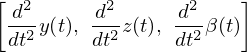

In [6]:
# Вектор обобщенных координат
q  = [y(t), z(t), beta(t)]

# Вектор обобщенных скоростей (производная от q)
dq = [sp.diff(var,t) for var in q]

# Вектор обобщенных ускорений (производная от dq)
d2q = [sp.diff(var,t) for var in dq]
d2q

### Силы

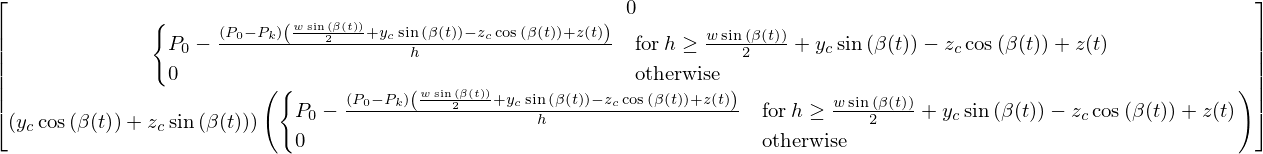

In [7]:
# Столбец [Fy Fz Mx] -- метрвые три строки правой части
FyzMx = sp.Matrix([0,P,P*(zc*sp.sin(beta(t)) + yc*sp.cos(beta(t)))]) 
FyzMx

### Уравнения связей

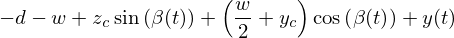

In [8]:
# Уравнение связи для точки В
f_B = y(t) + zc * sp.sin(beta(t)) + (w/2 + yc)*sp.cos(beta(t)) - w - d
f_B

In [9]:
# Уравнение связи для точки А
f_A = w*sp.cos(beta(t))**2 + (Ld-z(t)+zc*sp.cos(beta(t))+0*(w/2-yc)*sp.sin(beta(t)))*sp.sin(beta(t))-(w+d)*sp.cos(beta(t))
f_A

In [10]:
# Вторые производные уравнений связи
d2f_B = sp.diff(f_B,t,2)
d2f_A = sp.diff(f_A,t,2)

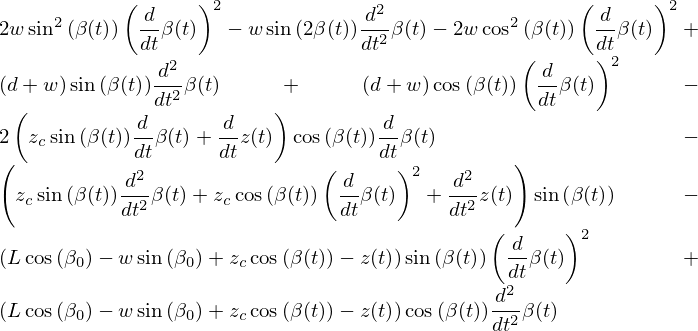

In [11]:
# ...выглядят эти производные довольно громоздко даже после попытки упрощения (метод simplify)
d2f_A.simplify()

Коэффициенты при вторых производных обобщенных координат в уравнении связи $d^2f_A/dt^2 = 0$. Другими словами, матрица-строка $Q_A = [Q_{Ay}, Q_{Az}, Q_{A\beta}]$:

In [12]:
QA = [ d2f_A.expand().coeff(var) for var in d2q ]
QA

Коэффициенты при вторых производных обобщенных координат в уравнении связи $d^2f_B/dt^2 = 0$ -- матрица-строка $Q_B = [Q_{By}, Q_{Bz}, Q_{B\beta}]$:

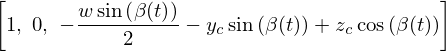

In [13]:
QB = [ d2f_B.expand().coeff(var) for var in d2q ]
QB

В правую часть уравнений движения пойдут все слагаемые, в которые не ходят вторые производные обобщенных координат. Используем для этого метод [as_independent](https://docs.sympy.org/latest/modules/core.html#sympy.core.expr.Expr.as_independent). Эти слагаемые составляют $\Phi_B$:

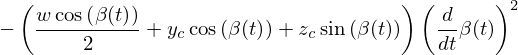

In [14]:
Phi_B = d2f_B.expand().as_independent(*d2q)[0].simplify()
Phi_B

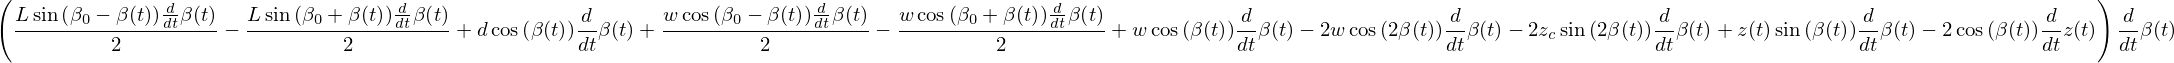

In [15]:
Phi_A = d2f_A.expand().as_independent(*d2q)[0].simplify()
Phi_A

## Переход от символьных выражений к их числовым значениям (подстановка)

В полученных выше аналитических выражениях при численном интегрировании необходимо выполнять замены символов их соответсвующими числовыми значениями. Для замены можно использоваться метод subs выражения sympy, например, для подстановки в выражение Phi_B значений $w = 0.1$ и $y_c=0$ можно вызвать метод subs, передав ему список замен:

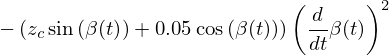

In [16]:
Phi_B.subs([ [w, 0.1], [yc, 0.0] ])

В эту же функцию можно передать словарь:

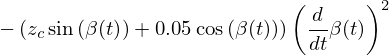

In [17]:
Phi_B.subs({w: 0.1, yc: 0.0})

Наиболее быстрый способ -- использование функции [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html). Возьмем для примера выражение Phi_B, которое зависит от угла поврота, угловой скорости наноспутника и параметров w, yc, zc

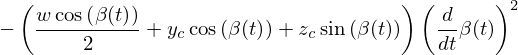

In [18]:
Phi_B

При помощи функции lambdify определим функцию, которая будет вычислять значение этого выражения для заданных числовых параметров. Первый аргумент функции lambdify -- список символов, которые содержаться в вычисляемом выражении, второй аргумент -- само символьное выражение.

In [19]:
n_Phi_B = lambdify( [beta(t), sp.diff(beta(t),t), w, yc, zc], Phi_B )

Результатом работы lambdify является объект типа функция, которую можно вызвать с заданными числовыми значениями

In [20]:
n_Phi_B(0.1,0.1,0.01,0.1,0.1)

Для удобства, чтобы вручную не перечислять параметры выражений, определим список, который будет включать в себя и вектор состояния наноспутника $q=(y,z,\beta,\dot{y},\dot{z},\dot{\beta})$ и его параметры. Этот список будет списком аргументов всех вычисляемых функций, которые будут построены на основе символьных выражений при помощи [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html)

In [21]:
# Определим список параметров наноспутника  

# Наноспутника типоразмера 3U массой 3 кг, с центром масс, 
# смещенным на 10 мм от продольной оси и на 50 мм от середины к толкателю
# Максимальный зазор между наноспутником и контейнером 1 мм
# Толкатель работает на ходе 200 мм
params = {m: 3.0, J: 0.021, L: 0.340, w: 0.100, d: 0.001, yc: 0.010, zc: 0.340/2.0 - 0.05, P0: 7, Pk: 2, h: 0.220}

# Вектор начальных условий, зависящий от параметров наноспутника и контейнера
q0 = get_q0(params)
# Добавим к этому списку нулевые начальные скорости
q0.extend([0.0,0.0,0.0])
# Добавим в словарь параметров вычисляемое значение beta_0
params[beta0] = q0[2]

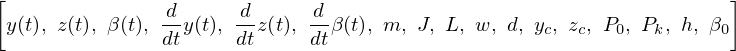

In [22]:
# а теперь определим объединенный список переменных состояния и параметров 
state_and_params = list([*q,*dq,*params.keys()])
state_and_params

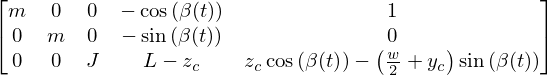

In [23]:
# Первые три строки матрицы коэффициентов правой части уравнений движения
# Символьное выражение sympy (матрица)
mass_matrix = sp.Matrix([[m, 0, 0, -sp.cos(beta(t)), 1],
                         [0, m, 0, -sp.sin(beta(t)), 0],
                         [0, 0, J, L-zc, zc*sp.cos(beta(t))-(w/2+yc)*sp.sin(beta(t))]])

# Создаем функцию-вычислитель для этого блока матрицы
n_mass_matrix = lambdify(state_and_params, mass_matrix)

# Исходное символьное выражение
mass_matrix

In [24]:
# Вычисляем значение mass_matrix для конкретных значений
# Для примера передаем в функцию n_mass_matrix вектор начального состояния наноспутника q0, определенный выше, 
# и значения параметров  
n_mass_matrix(*[*q0,*params.values()])

array([[ 3.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -9.99995671e-01,  1.00000000e+00],
       [ 0.00000000e+00,  3.00000000e+00,  0.00000000e+00,
        -2.94244971e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.10000000e-02,
         2.20000000e-01,  1.19822934e-01]])

In [25]:
# Матрица коэффициентов уравений связей 
Q_matrix = sp.Matrix([QA, QB])
# и её вычисляемое выражение 
n_Q_matrix = lambdify(state_and_params, Q_matrix)

In [26]:
# Матрица правых частей уравнений связей
Phi_matrix = sp.Matrix([-Phi_A, -Phi_B])
# вычислитель
n_Phi_matrix = lambdify(state_and_params, Phi_matrix)

In [27]:
# Первые три строки матрицы-столбца правой части (активные силы и момент, действующие на наноспутник)
n_FyzMx = lambdify(state_and_params,FyzMx)

# Координата z точки B
n_zb = lambdify(state_and_params, zb)

Собираем матрицу коэффицентов левой части дифференциальных уравнений и матрицу-столбец правой части

In [28]:
def get_A_matrix(t, qt, params, stage):
    A = np.zeros((5,5),dtype=float)
    A[0:3,:]   = n_mass_matrix(*[*qt,*params.values()])
    A[3:5,0:3] = n_Q_matrix(*[*qt,*params.values()])
    if stage == 2:
        # RA = 0
        A[3,:] = 0
        A[3,3] = 1       
    if stage == 3:
        # RA = 0 и RB = 0
        A[3,:] = 0
        A[4,:] = 0
        A[4,4] = 1       
        A[3,3] = 1    
    return A
    
def get_B_matrix(t, qt, params, stage):
    B = np.zeros((5,1), dtype=float)
    B[0:3] = n_FyzMx(*[*qt,*params.values()])
    B[3:5] = n_Phi_matrix(*[*qt,*params.values()])    
    if stage == 2:
        # RA = 0
        B[3] = 0 
    if stage==3:
        # RA = 0 и RB = 0
        B[3] = 0
        B[4] = 0 
    return B    

## Численное интегрирование

#### Функция правых частей дифференциальных уравнений

In [29]:
def dydt(t,y):
    A = get_A_matrix(t, y, params, STAGE)
    B = get_B_matrix(t, y, params, STAGE)
    # Реашем систему линейных уравнений
    X = linalg.solve(A,B.flatten())        
    res = np.zeros(len(y), dtype=float)
    # копируем скорости
    res[0:3] = y[3:6]
    # записываем ускорения    
    res[3:6] = X[0:3]
    return res

#### Функции для остановки интегрирования при выполнении некоторых условий

In [30]:
def Ra_eq_0(t, y):
    # Функция-"детектор", передаваемая в интегратор (параметр events), 
    # для остановки процесса интегрирования    
    # при Ra = 0 -- переход с этапа движения 1 к этапу 2
    A = get_A_matrix(t, y, params, STAGE)    
    B = get_B_matrix(t, y, params, STAGE)
    X = linalg.solve(A,B.flatten())   
    return X[3]

# функция-детектор активна
Ra_eq_0.terminal  = True

# функция определяется условие Ra = 0 при убывании Ra
Ra_eq_0.direction = -1

def Rb_eq_0(t, y):
    # Функция-"детектор", передаваемая в интегратор (параметр events), 
    # для остановки процесса интегрирования    
    # при Rb = 0 -- переход с этапа движения 2 к этапу 3
    A = get_A_matrix(t, y, params, STAGE)    
    B = get_B_matrix(t, y, params, STAGE)
    X = linalg.solve(A,B.flatten())      
    return X[4]

# функция определяется условие Rb = 0 при убывании Rb
Rb_eq_0.direction = -1
# функция-детектор активна
Rb_eq_0.terminal  = True

In [38]:
STAGE = 1
# Интегрируем пока Ra > 0
sol_1 = solve_ivp(dydt, [0, 0.5], q0, events = [Ra_eq_0], 
                  rtol = 1e-6, method="LSODA",minstep=0.01)

STAGE = 2
# Интегрируем пока Rb > 0
sol_2 = solve_ivp(dydt, [sol_1.t[-1], sol_1.t[-1]+0.5], sol_1.y[:,-1], events = [Rb_eq_0], 
                  rtol = 1e-6, method="LSODA", minstep=0.01)

STAGE = 3
# Свободное движение наноспутника
sol_3 = solve_ivp(dydt, [sol_2.t[-1], sol_2.t[-1]+0.5], sol_2.y[:,-1], 
                  rtol = 1e-8, method="LSODA", minstep=0.01)

#### Зависимость линейной скорости наноспутника от времени

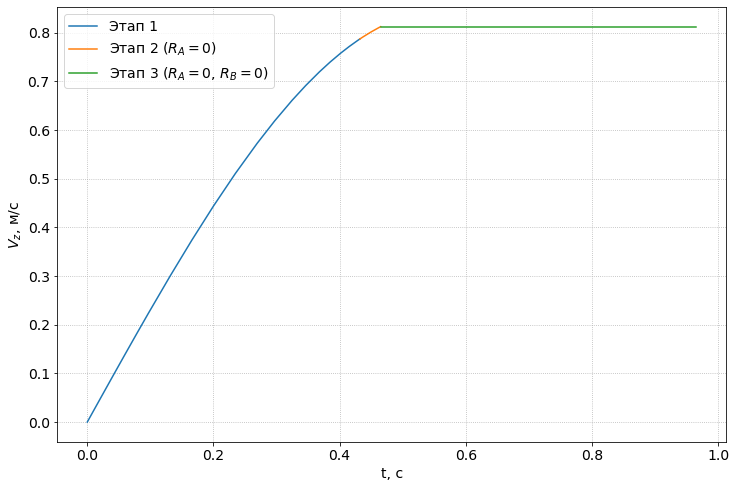

In [41]:
plt.plot(sol_1.t, sol_1.y[4]);
plt.plot(sol_2.t, sol_2.y[4]);
plt.plot(sol_3.t, sol_3.y[4]);
plt.xlabel('t, c');
plt.ylabel('$V_z$, м/с');
plt.grid(linestyle=':')
plt.legend(['Этап 1','Этап 2 ($R_A=0$)','Этап 3 ($R_A=0$, $R_B=0$)']);

#### Зависимость угловой скорости наноспутника от времени

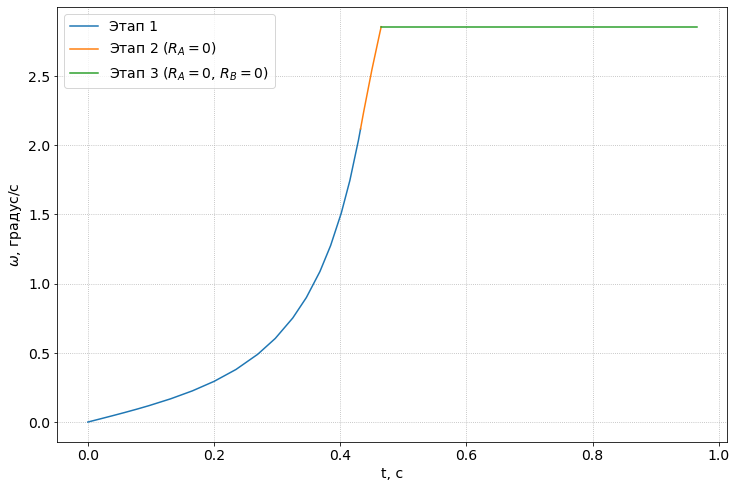

In [42]:
plt.plot(sol_1.t, sol_1.y[5]*180/np.pi);
plt.plot(sol_2.t, sol_2.y[5]*180/np.pi);
plt.plot(sol_3.t, sol_3.y[5]*180/np.pi);
plt.xlabel('t, c');
plt.ylabel('$\omega$, градус/с');
plt.grid(linestyle=':')
plt.legend(['Этап 1','Этап 2 ($R_A=0$)','Этап 3 ($R_A=0$, $R_B=0$)']);

#### Проверяем уравнения связей

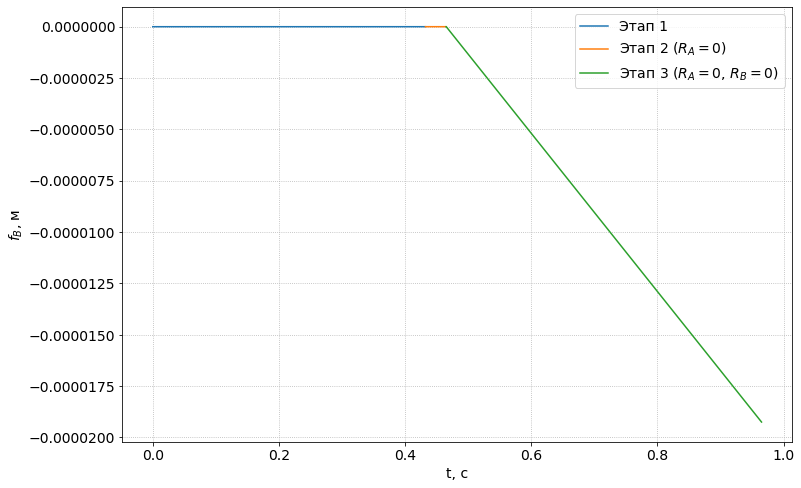

In [43]:
n_f_B=lambdify(state_and_params, f_B)
sol_f_B = [ [ n_f_B(*[*yi,*params.values()]) for yi in sol.y.transpose()] for sol in (sol_1,sol_2,sol_3) ]

plt.plot(sol_1.t, sol_f_B[0]);
plt.plot(sol_2.t, sol_f_B[1]);
plt.plot(sol_3.t, sol_f_B[2]);
plt.xlabel('t, c');
plt.ylabel('$f_B$, м');
plt.grid(linestyle=':')
plt.legend(['Этап 1','Этап 2 ($R_A=0$)','Этап 3 ($R_A=0$, $R_B=0$)']);

# Уравнение связи fB = 0 работает на первых двух этапах 

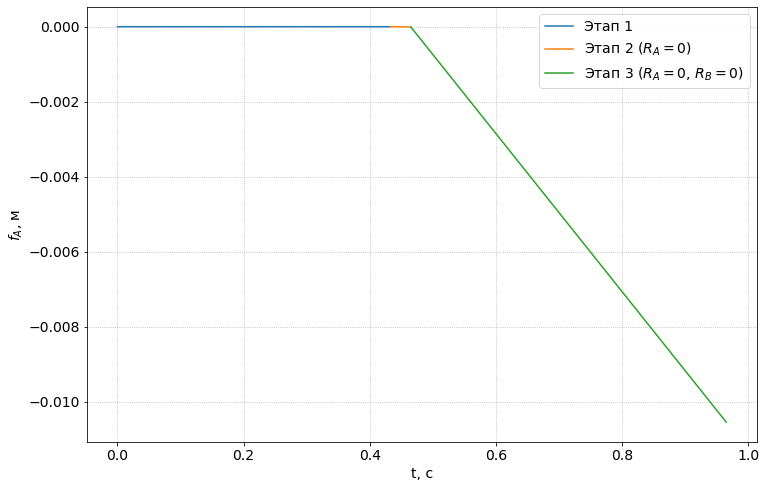

In [44]:
n_f_A=lambdify(state_and_params, f_A)
sol_f_A = [ [ n_f_A(*[*yi,*params.values()]) for yi in sol.y.transpose()] for sol in (sol_1,sol_2,sol_3) ]

plt.plot(sol_1.t, sol_f_A[0]);
plt.plot(sol_2.t, sol_f_A[1]);
plt.plot(sol_3.t, sol_f_A[2]);
plt.xlabel('t, c');
plt.ylabel('$f_A$, м');
plt.grid(linestyle=':')
plt.legend(['Этап 1','Этап 2 ($R_A=0$)','Этап 3 ($R_A=0$, $R_B=0$)']);

# Уравнение связи fa = 0 работает на первом этапе 

#### Перемещение точки $z_B$

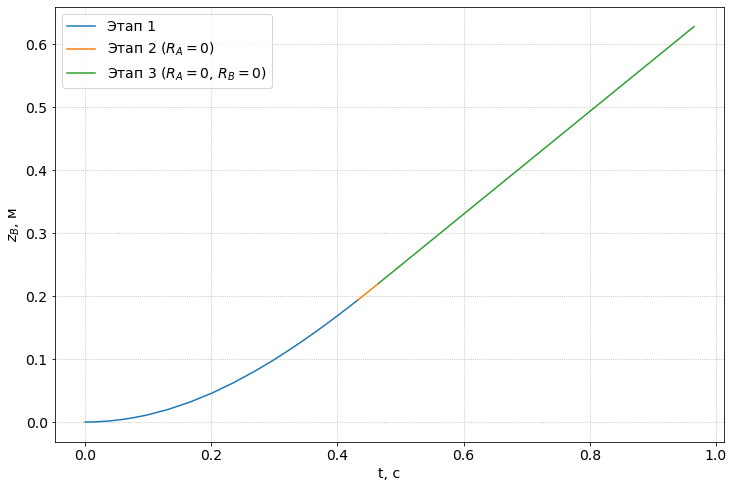

In [45]:
sol_zb = [ [ n_zb(*[*yi,*params.values()]) for yi in sol.y.transpose()] for sol in (sol_1,sol_2,sol_3) ]

plt.plot(sol_1.t, sol_zb[0]);
plt.plot(sol_2.t, sol_zb[1]);
plt.plot(sol_3.t, sol_zb[2]);
plt.xlabel('t, c');
plt.ylabel('$z_B$, м');
plt.grid(linestyle=':')
plt.legend(['Этап 1','Этап 2 ($R_A=0$)','Этап 3 ($R_A=0$, $R_B=0$)']);

# Уравнение связи fa = 0 работает на первом этапе 

#### Сила толкателя, действующая на наноспутник

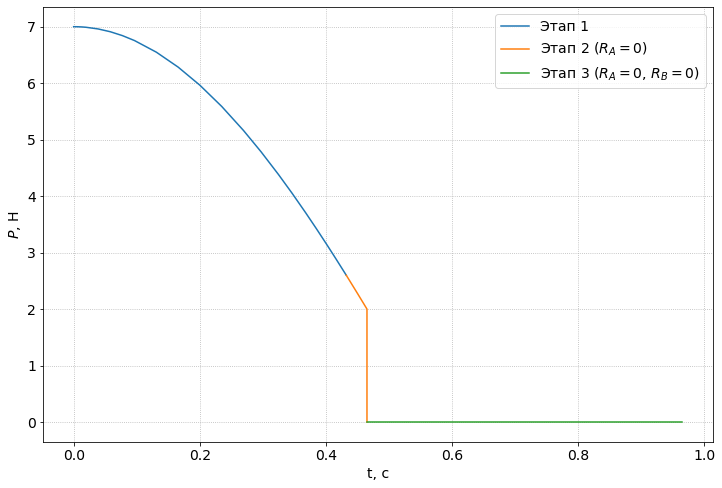

In [47]:
n_P = lambdify(state_and_params, P)

sol_P = [ [ n_P(*[*yi,*params.values()]) for yi in sol.y.transpose()] for sol in (sol_1,sol_2,sol_3) ]

plt.plot(sol_1.t, sol_P[0]);
plt.plot(sol_2.t, sol_P[1]);
plt.plot(sol_3.t, sol_P[2]);
plt.xlabel('t, c');
plt.ylabel('$P$, Н');
plt.grid(linestyle=':')
plt.legend(['Этап 1','Этап 2 ($R_A=0$)','Этап 3 ($R_A=0$, $R_B=0$)']);